# Pileups and average features

Welcome to the cooltools pileups notebook!
 
Averaging Hi-C/Micro-C maps allows the quantification of general patterns observed in the maps. Averaging comes in various forms: contact-vs-distance plots, saddle plots, and pileup plots. **Pileup plots** are the averaged local Hi-C map over the 2D windows (i.e. **snippets**). These are also referred to as "average Hi-C maps". Pileups can be useful for determining the relationship between features (e.g. CTCF and TAD boundaries). Pileups can also be beneficial for reliably observing features in low-coverage Hi-C or single-cell HiC maps.

For pileups, we retrieve local windows that are centered at the **anchors**. We call this procedure **snipping**. Anchors can be ChIP-Seq binding sites, anchors of dots, or any other genomic features. Pileups come in two varieties: 

- **On-diagonal pileup**. Each window is centered at the pixel located at the anchor position, at the main diagonal. Both coordinates of the window center are equivalent to the bin of the anchor. 
- **Off-diagonal pileup**. Each window is centered at the pixel with one anchor as a left coordinate and another anchor as a right coordinate. 

Typically, the sizes of windows are equivalent. After the selection of windows, we average them elementwise. 

Content:

1. Download data
2. Load data
    - Load genomic regions
    - Load features for anchors
3. On-diagonal pipeup of CTCF
    - On-diagonal pileup of ICed Hi-C interactions
    - On-diagonal pileup of observed over expected interactions
    - Inspect the snips
4. Off-diagonal pileup of CTCF

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# import libraries for biological data analysis
import cooler
import bioframe

import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.0'):
    raise AssertionError("tutorials rely on cooltools version 0.5.0 or higher,"+
                         "please check your cooltools version and update to the latest")


## Download data

For the test, we collected the data from [immortalized human foreskin fibroblast cell line HFFc6](https://data.4dnucleome.org/ontology-terms/EFO:0009318/):

- Micro-C data from [Krietenstein et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32213324/)
- ChIP-Seq for CTCF from [ENCODE ENCSR000DWQ](https://www.encodeproject.org/experiments/ENCSR000DWQ/)

You can automatically download test datasets with cooltools. More information on the files and how they were obtained is available from the datasets description. 


In [4]:
# Print available datasets for download
cooltools.print_available_datasets()

1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
	Downloaded from https://osf.io/3h9js/download 
	Stored as test.mcool 
	Original md5sum: e4a0fc25c8dc3d38e9065fd74c565dd1

2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
	Downloaded from https://osf.io/w92u3/download 
	Stored as test_CTCF.bigWig 
	Original md5sum: 62429de974b5b4a379578cc85adc65a3

3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
	Downloaded from https://osf.io/c9pwe/download 
	Stored as test_CTCF.bed.gz 
	Original md5sum: 61ecfdfa821571a8e0ea362e8fd48f63



In [5]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')
ctcf_fc_file = cooltools.download_data("HFF_CTCF_fc", cache=True, data_dir='./')

## Load data

### Load genomic regions

The pileup function needs **genomic regions**. Why?

- First, pileup uses regions for parallelization of snipping. Different genomic regions are loaded simultaneously by different processes, and the snipping can be done in parallel. 
- Second, the observed over expected pileup requires calculating expected interactions before snipping (P(s), in other words). Typically, P(s) is calculated separately for each chromosome arm as inter-arms interactions might be affected by strong insulation of centromeres or Rabl configuration. 

For species that do not have information on chromosome arms, or have *telocentric chromosomes* (e.g., mouse), you may want to use full chromosomes instead. 

In [6]:
# Open cool file with Micro-C data:
clr = cooler.Cooler('./test.mcool::/resolutions/10000')
# Set up selected data resolution:
resolution = clr.binsize

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

### Load features for anchors

Construction of the pileup requires  genomic **features** that will be used for centering of the **snippets**. In this example, we will use *positions of motifs in CTCF peaks* as features. 

In [8]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf['mid'] = (ctcf.end+ctcf.start)//2
ctcf.head()

,chrom,start,end,name,score,strand,mid
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-,118494
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+,144011
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-,163685
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+,164720
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-,309425


#### Feature inspection and filtering

Since we have both the list of strongest motifs of CTCF located in CTCF ChIP-Seq and the fold change over input for the genome, we have two characteristics of each feature: 

- score of the motif
- CTCF ChIP-Seq fold-change over input

Let's take a look at joint distribution of these scores: 

In [9]:
import bbi
from scipy.stats import linregress

In [10]:
# Get CTCF ChIP-Seq fold-change over input for genomic regions centered at the positions of the motifs

flank = 250 # Length of flank to one side from the boundary, in basepairs
ctcf_chip_signal = bbi.stackup(
    ctcf_fc_file, 
    ctcf.chrom, 
    ctcf.mid-flank, 
    ctcf.mid+flank, 
    bins=1)

ctcf['FC_score'] = ctcf_chip_signal

In [11]:
ctcf['quartile_score']    = pd.qcut(ctcf['score'], 4, labels=False) + 1
ctcf['quartile_FC_score'] = pd.qcut(ctcf['FC_score'], 4, labels=False) + 1
ctcf['peaks_importance'] = ctcf.apply(
    lambda x: 'Top by both scores' if x.quartile_score==4 and x.quartile_FC_score==4 else
                'Top by Motif score' if x.quartile_score==4 else
                'Top by FC score' if x.quartile_FC_score==4 else 'Ordinary peaks', axis=1
)

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


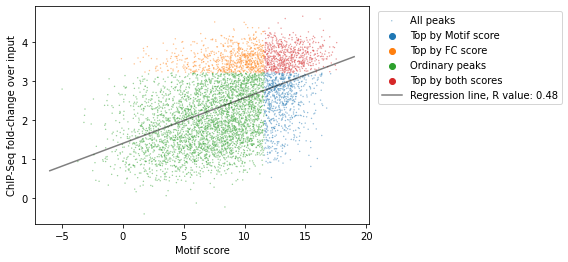

In [12]:
x = ctcf['score']
y = np.log(ctcf['FC_score'])

fig, ax = plt.subplots()

sns.scatterplot(x, y, hue=ctcf['peaks_importance'],
    s=2,
    alpha=0.5,
    label='All peaks', 
    ax=ax
)

slope, intercept, r, p, se = linregress(x, y)

ax.plot([-6, 19], [intercept-6*slope, intercept+19*slope], 
        alpha=0.5,
        color='black',
        label=f"Regression line, R value: {r:.2f}")

ax.set(
    xlabel='Motif score',
    ylabel='ChIP-Seq fold-change over input')

ax.legend(bbox_to_anchor=(1.01,1), loc="upper left")

plt.show()

In [13]:
# Select the CTCF sites that are in top quartile by both the ChIP-Seq data and motif score

sites = ctcf[ctcf['peaks_importance']=='Top by both scores']\
    .sort_values('FC_score', ascending=False)\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score,quartile_score,quartile_FC_score,peaks_importance
659,chr17,8158938,8158957,MA0139.1_CTCF_human,13.276979,-,8158947,25.056849,4,4,Top by both scores
660,chr2,176127201,176127220,MA0139.1_CTCF_human,12.820343,+,176127210,25.027294,4,4,Top by both scores
661,chr17,38322364,38322383,MA0139.1_CTCF_human,13.534864,-,38322373,25.010430,4,4,Top by both scores
662,chr2,119265336,119265355,MA0139.1_CTCF_human,13.739862,-,119265345,24.980141,4,4,Top by both scores
663,chr2,118003514,118003533,MA0139.1_CTCF_human,12.646685,-,118003523,24.957502,4,4,Top by both scores


In [14]:
# Some CTCF sites might be located too close in the genome and interfere with analysis. 
# We will collapse the sites falling into the same size genomic bins as the resolution of our micro-C data:
sites = bioframe.cluster(sites, min_dist=resolution)\
    .drop_duplicates('cluster')\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score,quartile_score,quartile_FC_score,peaks_importance,cluster,cluster_start,cluster_end
608,chr17,8158938,8158957,MA0139.1_CTCF_human,13.276979,-,8158947,25.056849,4,4,Top by both scores,34,8158938,8158957
609,chr2,176127201,176127220,MA0139.1_CTCF_human,12.820343,+,176127210,25.027294,4,4,Top by both scores,515,176127201,176127220
610,chr17,38322364,38322383,MA0139.1_CTCF_human,13.534864,-,38322373,25.010430,4,4,Top by both scores,104,38322364,38322383
611,chr2,119265336,119265355,MA0139.1_CTCF_human,13.739862,-,119265345,24.980141,4,4,Top by both scores,465,119265336,119265355
612,chr2,118003514,118003533,MA0139.1_CTCF_human,12.646685,-,118003523,24.957502,4,4,Top by both scores,462,118003514,118003533


## On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. cooltools will create a snippet of Hi-C map for each feature. Then you can combine them into a single 2D pileup. 

### On-diagonal pileup of ICed Hi-C interactions

In [15]:
stack = cooltools.pileup(clr, sites, view_df=hg38_arms, flank=300_000)
# Mirror reflect snippets when the feature is on the opposite strand
mask = np.array(sites.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]

# Aggregate. Note that some pixels might be converted to NaNs after IC, thus we aggregate by nanmean: 
mtx = np.nanmean(stack, axis=2)

In [16]:
# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

/var/folders/4s/d866wm3s4zbc9m41334fxfwr0000gp/T/ipykernel_47165/2426526626.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(mtx),


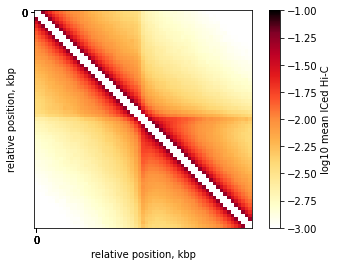

In [17]:
plt.imshow(
    np.log10(mtx),
    vmin = -3,
    vmax = -1,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()

### On-diagonal pileup of observed over expected interactions

Sometimes you don't want to include the **distance decay** P(s) in your pileups. For example, when you make comparison of pileups between experiments and they have different P(s). Even if these differences are slight, they might affect the pileup of raw ICed Hi-C interactions. 

In this case, the observed over expected pileup is your choice. Prior to running the pileup function, you need to calculate expected interactions for chromosome arms.

In [18]:
expected = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2, chunksize=1_000_000)

In [19]:
expected

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr2_p,chr2_p,0,8771,NaN,NaN,NaN,NaN,NaN,NaN
1,chr2_p,chr2_p,1,8753,NaN,NaN,NaN,NaN,0.000495,0.000520
2,chr2_p,chr2_p,2,8745,2656738.0,406.013088,303.800800,0.046428,0.042469,0.044728
3,chr2_p,chr2_p,3,8741,1563363.0,237.585271,178.854021,0.027181,0.026796,0.028226
4,chr2_p,chr2_p,4,8738,1125674.0,169.308714,128.825132,0.019376,0.019097,0.020152
...,...,...,...,...,...,...,...,...,...,...
32543,chr17_q,chr17_q,5850,0,0.0,0.000000,NaN,NaN,0.000010,0.000006
32544,chr17_q,chr17_q,5851,0,0.0,0.000000,NaN,NaN,0.000010,0.000006
32545,chr17_q,chr17_q,5852,0,0.0,0.000000,NaN,NaN,0.000010,0.000006
32546,chr17_q,chr17_q,5853,0,0.0,0.000000,NaN,NaN,0.000010,0.000006


In [20]:
# Create the stack of snips:
stack = cooltools.pileup(clr, sites, view_df=hg38_arms, expected_df=expected, flank=300_000) 

# Mirror reflect snippets when the feature is on the opposite strand
mask = np.array(sites.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]
    
mtx = np.nanmean(stack, axis=2)

/var/folders/4s/d866wm3s4zbc9m41334fxfwr0000gp/T/ipykernel_47165/2557000624.py:2: RuntimeWarning: divide by zero encountered in log2
  np.log2(mtx),


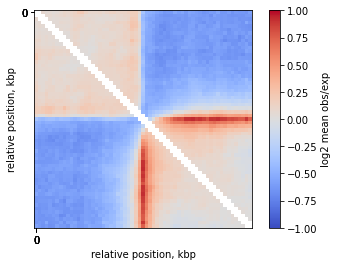

In [21]:
plt.imshow(
    np.log2(mtx),
    vmax = 1.0,
    vmin = -1.0,
    cmap='coolwarm',
    interpolation='none')

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()

### Inspect the snips

Aggregation is a convenient though dangerous step. It averages your data so that you cannot distinguish whether the signal is indeed average, or there is a single dataset that introduces a bias to your analysis. To make sure there are no outliers, you may want to use inspection of individual snippets.

The cell below shows one way to interactively investigate snippets contributing to a pileup. Note that this is not interactive on readthedocs, but can be run if the notebook is obtained from [open2c_examples](https://github.com/open2c/open2c_examples). This widget sorts the dataframe with CTCF motifs by the strength of binding. This allows us to inspect the Micro-C maps at the positions of the strongest and weakest CTCF sites. Run the cell below and try to compare snippets with the lowest score to the snippets with the largest score. 

In [22]:
from ipywidgets import interact
from matplotlib.gridspec import GridSpec

n_examples = len(sites)

@interact(i=(0, n_examples-1))
def f(i):
    fig, ax = plt.subplots(figsize=[5,5])
    img = ax.matshow(
        np.log2(stack[:, :, i]),  
        vmin=-1,
        vmax=1,
        extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
        cmap='coolwarm'
    )
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(f'{i+1}-th snippet from top \n FC score: {sites.loc[i, "FC_score"]:.2f}\n and motif score: {sites.loc[i, "score"]:.2f}')
    plt.axvline(0, c='g', ls=':')
    plt.axhline(0, c='g', ls=':')

interactive(children=(IntSlider(value=306, description='i', max=612), Output()), _dom_classes=('widget-interac…

### Compare top strongest peaks with others

Compare the top peaks with both motif score and FC score to the rest of the peaks:

In [23]:
# Create the stack of snips:
stack = cooltools.pileup(clr, ctcf, view_df=hg38_arms, expected_df=expected, flank=300_000
            ) 

# Mirror reflect snippets where the feature is on the opposite strand
mask = np.array(ctcf.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]
    
mtx = np.nanmean(stack, axis=2)

/var/folders/4s/d866wm3s4zbc9m41334fxfwr0000gp/T/ipykernel_47165/2210978640.py:14: RuntimeWarning: divide by zero encountered in log2
  np.log2(mtx),


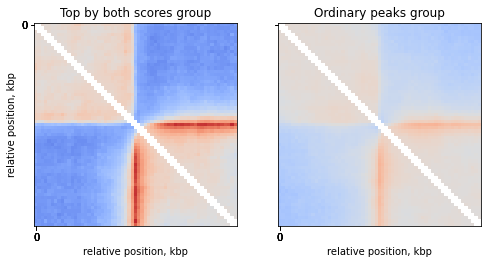

In [24]:
# TODO: add some strength of insulation for the pileup? 

groups = ['Top by both scores', 'Ordinary peaks']
n_groups = len(groups)

ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)

fig, axs = plt.subplots(1, n_groups, sharex=True, sharey=True, figsize=(4*n_groups, 4))
for i in range(n_groups):
    mtx = np.nanmean( stack[:, :, ctcf['peaks_importance']==groups[i]], axis=2)
    ax = axs[i]
    ax.imshow(
        np.log2(mtx),
        vmax = 1.0,
        vmin = -1.0,
        cmap='coolwarm',
        interpolation='none')
    
    ax.set(title=f'{groups[i]} group', 
           xticks=ticks_pixels, 
           xticklabels=ticks_kbp, 
           xlabel='relative position, kbp')

axs[0].set(yticks=ticks_pixels, 
       yticklabels=ticks_kbp, 
       ylabel='relative position, kbp')

plt.show()

## Off-diagonal pileup

**Off-diagonal pileups** are the averaged Hi-C maps around double anchors. In this case, the anchors are CTCF sites in the genome. 


In [25]:
paired_sites = bioframe.pair_by_distance(sites, min_sep=200000, max_sep=1000000, suffixes=('1', '2'))
paired_sites.loc[:, 'mid1'] = (paired_sites['start1'] + paired_sites['end1'])//2
paired_sites.loc[:, 'mid2'] = (paired_sites['start2'] + paired_sites['end2'])//2

In [26]:
print(len(paired_sites))
paired_sites.head()

1634


,chrom1,start1,end1,name1,score1,strand1,mid1,FC_score1,quartile_score1,quartile_FC_score1,...,score2,strand2,mid2,FC_score2,quartile_score2,quartile_FC_score2,peaks_importance2,cluster2,cluster_start2,cluster_end2
0,chr17,412407,412426,MA0139.1_CTCF_human,12.212548,+,412416,41.645123,4,4,...,13.272118,-,1056231,35.072572,4,4,Top by both scores,1,1056222,1056241
1,chr17,412407,412426,MA0139.1_CTCF_human,12.212548,+,412416,41.645123,4,4,...,13.996208,-,1187374,69.994562,4,4,Top by both scores,2,1187365,1187384
2,chr17,412407,412426,MA0139.1_CTCF_human,12.212548,+,412416,41.645123,4,4,...,14.735101,+,1259280,31.643758,4,4,Top by both scores,3,1259271,1259290
3,chr17,412407,412426,MA0139.1_CTCF_human,12.212548,+,412416,41.645123,4,4,...,13.983562,+,1276338,35.440247,4,4,Top by both scores,4,1276329,1276348
4,chr17,412407,412426,MA0139.1_CTCF_human,12.212548,+,412416,41.645123,4,4,...,12.045221,+,1365609,36.746886,4,4,Top by both scores,5,1365600,1365619


For pileup, we will use the expected calculated above:

In [27]:
# create the stack of snips:
stack = cooltools.pileup(clr, paired_sites, view_df=hg38_arms, expected_df=expected, flank=100_000)
    
mtx = np.nanmean(stack, axis=2)

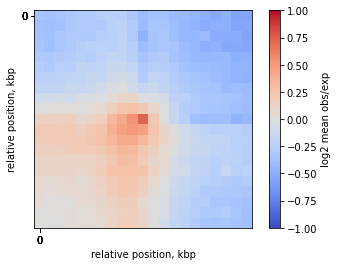

In [28]:
plt.imshow(
    np.log2(mtx),
    vmax = 1,
    vmin = -1,
    cmap='coolwarm')

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()